In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import cv2
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set paths
data_dir = Path("../data/raw/PlantVillage")

# Get all class folders
classes = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
print(f"Total classes found: {len(classes)}")
print("\nClasses:")
for i, cls in enumerate(classes, 1):
    print(f"{i}. {cls}")

Total classes found: 15

Classes:
1. Pepper__bell___Bacterial_spot
2. Pepper__bell___healthy
3. Potato___Early_blight
4. Potato___Late_blight
5. Potato___healthy
6. Tomato_Bacterial_spot
7. Tomato_Early_blight
8. Tomato_Late_blight
9. Tomato_Leaf_Mold
10. Tomato_Septoria_leaf_spot
11. Tomato_Spider_mites_Two_spotted_spider_mite
12. Tomato__Target_Spot
13. Tomato__Tomato_YellowLeaf__Curl_Virus
14. Tomato__Tomato_mosaic_virus
15. Tomato_healthy


CLASS DISTRIBUTION SUMMARY
                                      Class  Image_Count  Percentage
      Tomato__Tomato_YellowLeaf__Curl_Virus         3208   15.544895
                      Tomato_Bacterial_spot         2127   10.306731
                         Tomato_Late_blight         1908    9.245530
                  Tomato_Septoria_leaf_spot         1771    8.581674
Tomato_Spider_mites_Two_spotted_spider_mite         1676    8.121335
                             Tomato_healthy         1591    7.709454
                     Pepper__bell___healthy         1478    7.161894
                        Tomato__Target_Spot         1404    6.803314
                      Potato___Early_blight         1000    4.845666
                       Potato___Late_blight         1000    4.845666
                        Tomato_Early_blight         1000    4.845666
              Pepper__bell___Bacterial_spot          997    4.831129
                           Tomato_Leaf_Mold          952    4.613074
       

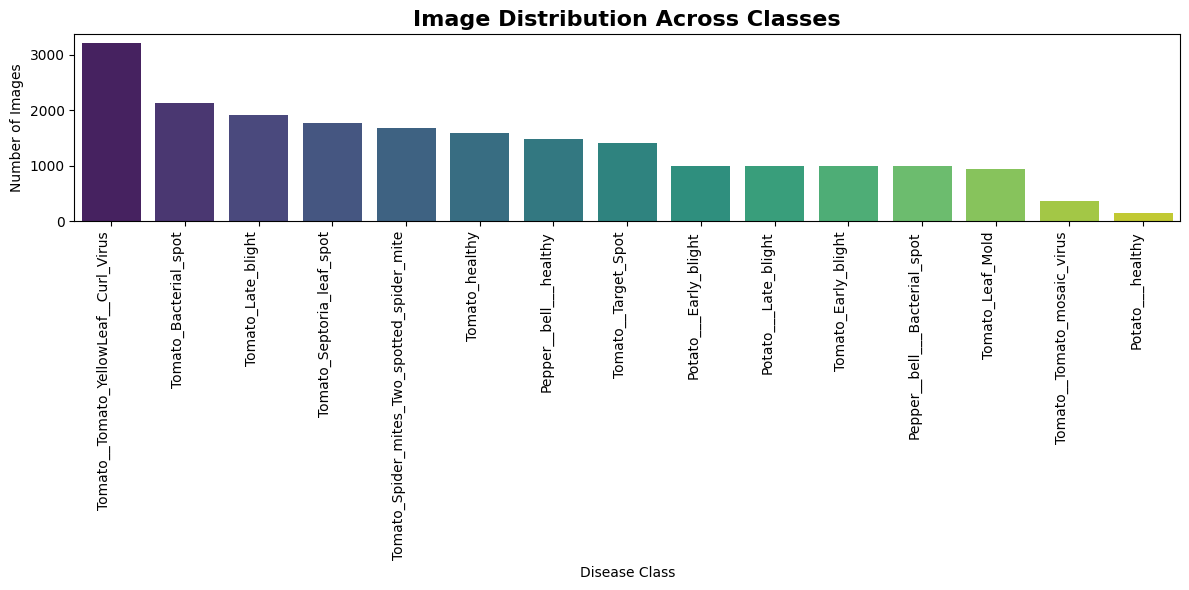


Class Imbalance Ratio: 21.11
Consider using class weights during training


In [3]:
# Count images per class
class_counts = {}
all_image_paths = []

for class_name in classes:
    class_path = data_dir / class_name
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.JPG")) + \
             list(class_path.glob("*.png")) + list(class_path.glob("*.PNG"))
    class_counts[class_name] = len(images)
    all_image_paths.extend(images)

# Image data summary
df_distribution = pd.DataFrame({
    'Class': list(class_counts.keys()),
    'Image_Count': list(class_counts.values())
})

df_distribution['Percentage'] = (df_distribution['Image_Count'] / df_distribution['Image_Count'].sum()) * 100
df_distribution = df_distribution.sort_values('Image_Count', ascending=False)

print("CLASS DISTRIBUTION SUMMARY")
print(df_distribution.to_string(index=False))
print(f"\nTotal Images: {df_distribution['Image_Count'].sum()}")
print(f"Min images per class: {df_distribution['Image_Count'].min()}")
print(f"Max images per class: {df_distribution['Image_Count'].max()}")
print(f"Mean images per class: {df_distribution['Image_Count'].mean():.2f}")
print(f"Std Dev: {df_distribution['Image_Count'].std():.2f}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=df_distribution, x='Class', y='Image_Count', palette='viridis')
plt.xticks(rotation=90, ha='right')
plt.title('Image Distribution Across Classes', fontsize=16, fontweight='bold')
plt.xlabel('Disease Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.savefig('../data/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Check for severe class imbalance
max_count = df_distribution['Image_Count'].max()
min_count = df_distribution['Image_Count'].min()
imbalance_ratio = max_count / min_count
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print("WARNING: Significant class imbalance detected!")
    print("Consider using class weights during training")
else:
    print(" Classes are balanced")

## Class Distribution Analysis

### Inferences
The dataset demonstrates a **significant class imbalance** with a ratio of **21.11** between the majority and minority classes.

*   **Dominant Class**: `Tomato_YellowLeaf__Curl_Virus` (15.5%) - The model will naturally bias its predictions toward this class.
*   **Minority Class**: `Potato___healthy` (0.7%) - With only 152 images, the model may struggle to learn robust features for healthy potatoes, potentially leading to high false-positive rates (classifying healthy potatoes as diseased).
*   **General Trend**: Tomato diseases are overrepresented compared to Potato and Pepper classes.

### Implications
* Global accuracy will be a misleading metric. A model could ignore the minority classes and still achieve ~90% accuracy.
* The model may perform poorly on real-world data for underrepresented classes (e.g., Potato Late Blight vs. Healthy).

### Processing Actions
To mitigate the imbalance, I will implement the following

- Ensure training and validation sets maintain the same class distribution as the original dataset. I have to do this before augumentation
- Calculate and apply class weights to the Loss function to penalize misclassifications of minority classes more heavily.
- Consider **augmentation-based oversampling** for minority classes (e.g., apply more aggressive augmentation to classes with < 500 images to synthetically increase their representation).
-  Use **Macro F1-Score** and **Confusion Matrix** as primary evaluation metrics not just accuracy.


Analyzing image properties

IMAGE PROPERTIES SUMMARY
         width   height      channels  file_size_kb
count  20637.0  20637.0  20637.000000  20637.000000
mean     256.0    256.0      3.000048     16.194096
std        0.0      0.0      0.006961      4.503864
min      256.0    256.0      3.000000      3.359375
25%      256.0    256.0      3.000000     12.755859
50%      256.0    256.0      3.000000     16.601562
75%      256.0    256.0      3.000000     19.378906
max      256.0    256.0      4.000000    118.800781

IMAGE FORMATS
JPEG    20636
PNG         1
Name: count, dtype: int64

COLOR MODES
RGB     20636
RGBA        1
Name: count, dtype: int64

ANOMALY DETECTION

 No corrupted images found


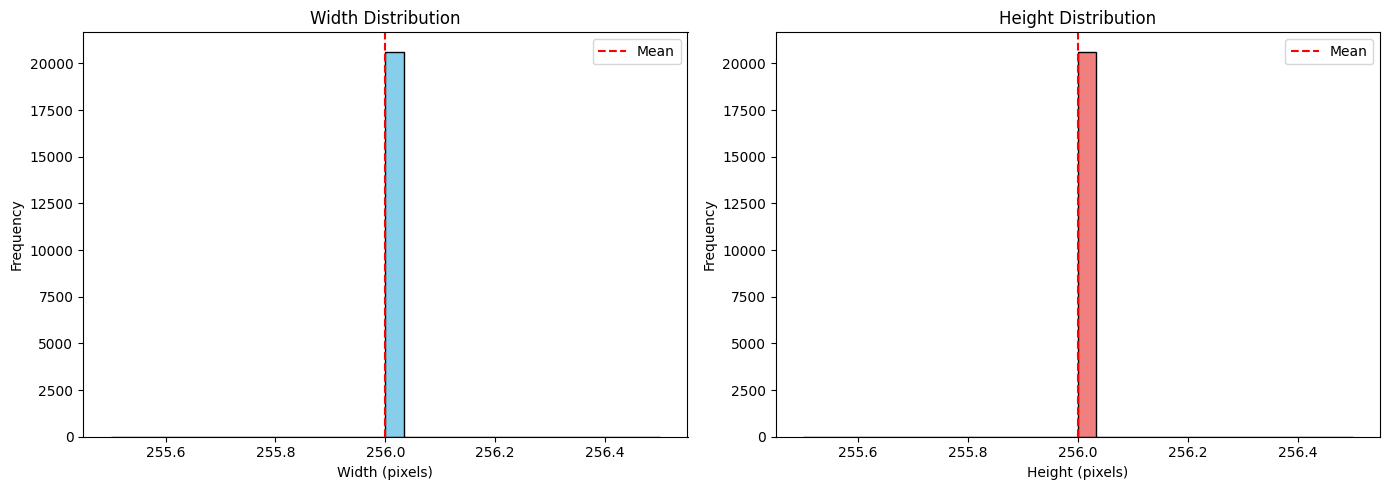

In [4]:
# Sample images to analyze properties
sample_size = min(30000, len(all_image_paths))
sample_images = np.random.choice(all_image_paths, sample_size, replace=False)

image_properties = {
    'width': [],
    'height': [],
    'channels': [],
    'file_size_kb': [],
    'format': [],
    'mode': []
}

corrupted_images = []

print("\nAnalyzing image properties")
for img_path in sample_images:
    try:
        img = Image.open(img_path)
        image_properties['width'].append(img.width)
        image_properties['height'].append(img.height)
        image_properties['mode'].append(img.mode)
        image_properties['format'].append(img.format)
        
        # Count channels
        if img.mode == 'RGB':
            image_properties['channels'].append(3)
        elif img.mode == 'L':
            image_properties['channels'].append(1)
        elif img.mode == 'RGBA':
            image_properties['channels'].append(4)
        else:
            image_properties['channels'].append(len(img.getbands()))
        
        # File size
        file_size = os.path.getsize(img_path) / 1024  # KB
        image_properties['file_size_kb'].append(file_size)
        img.close()
    except Exception as e:
        corrupted_images.append((str(img_path), str(e)))
        print(f" Error reading {img_path}: {e}")

# Create summary DataFrame
df_properties = pd.DataFrame(image_properties)

print("\nIMAGE PROPERTIES SUMMARY")
print(df_properties.describe())

print("\nIMAGE FORMATS")
print(pd.Series(image_properties['format']).value_counts())

print("\nCOLOR MODES")
print(pd.Series(image_properties['mode']).value_counts())

# Check for anomalies
print("\nANOMALY DETECTION")

# Unusual dimensions
unusual_width = df_properties[
    (df_properties['width'] < 50) | (df_properties['width'] > 5000)
]
unusual_height = df_properties[
    (df_properties['height'] < 50) | (df_properties['height'] > 5000)
]

if len(unusual_width) > 0:
    print(f" Found {len(unusual_width)} images with unusual widths")
if len(unusual_height) > 0:
    print(f" Found {len(unusual_height)} images with unusual heights")

# Corrupted images
if corrupted_images:
    print(f"\n Found {len(corrupted_images)} corrupted images:")
    for path, error in corrupted_images:
        print(f"   - {path}: {error}")
else:
    print("\n No corrupted images found")

# Visualize dimensions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(image_properties['width'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Width Distribution')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(image_properties['width']), color='red', linestyle='--', label='Mean')
axes[0].legend()

axes[1].hist(image_properties['height'], bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Height Distribution')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(image_properties['height']), color='red', linestyle='--', label='Mean')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/image_dimensions.png', dpi=300)
plt.show()

## Image Properties Analysis

### Inferences
* All sampled images are **256x256 pixels**, simplifying preprocessing (no padding logic needed).
* All images are **RGB (3-channel)** in **JPEG** format, confirming consistency.
* Mean file size is small (`16 KB`), indicating significant JPEG compression (12:1 ratio). Fine texture details of diseases might be muted, though since PlantVillage was captured under controlled lab conditions, compression is uniform across all classes and unlikely to be a major problem in practice.
* 1 PNG image with RGBA (4 channels) detected and must be handled explicitly to avoid pipeline errors.

### Implications for Training
* 256x256 is ideal for standard CNNs (ResNet, EfficientNet, MobileNet), which typically expect **224x224** inputs.
* The model may rely more on shape/color features than fine texture due to compression artifacts.
* Avoid further JPEG compression augmentation to prevent quality degradation.

### Processing Actions Checklist
- **Convert any RGBA images to RGB** by dropping the alpha channel before any other processing step to prevent dimension mismatch errors.
- Resize/Crop to **224x224** (Standard ImageNet size).
    - Training: `RandomResizedCrop(224)` or `RandomCrop(224)`
    - Validation: `CenterCrop(224)`
- Normalize using **dataset-specific mean/std** derived from my pixel distribution analysis
    - `mean = [0.46, 0.48, 0.42]`
    - `std = [0.21, 0.18, 0.22]`
- Focus on geometric transforms (Flip, Rotate, ColorJitter) and avoid compression artifacts.


ASPECT RATIO ANALYSIS
Mean aspect ratio: 1.000
Std aspect ratio: 0.000
Min aspect ratio: 1.000
Max aspect ratio: 1.000
Aspect ratios are very consistent


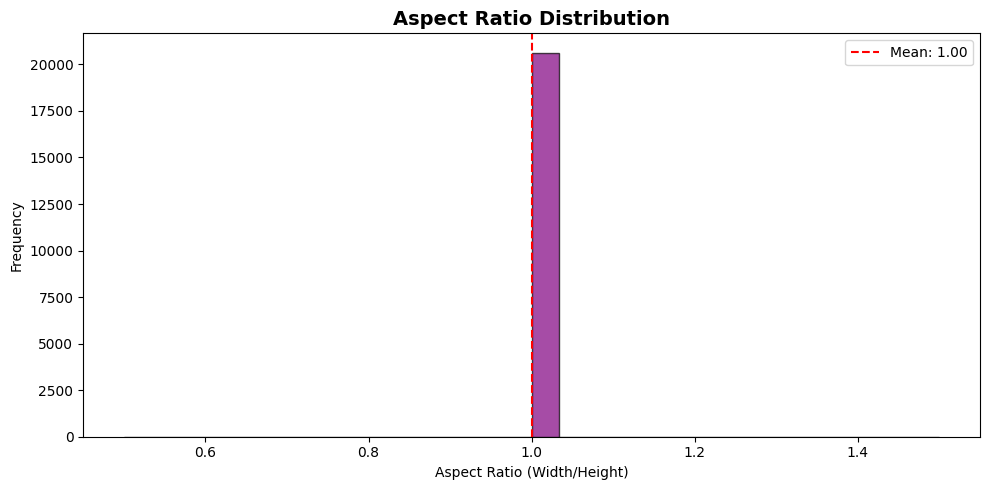

In [5]:
# Calculate aspect ratios
aspect_ratios = []
for w, h in zip(image_properties['width'], image_properties['height']):
    aspect_ratios.append(w / h)

df_properties['aspect_ratio'] = aspect_ratios

print("\nASPECT RATIO ANALYSIS")
print(f"Mean aspect ratio: {np.mean(aspect_ratios):.3f}")
print(f"Std aspect ratio: {np.std(aspect_ratios):.3f}")
print(f"Min aspect ratio: {np.min(aspect_ratios):.3f}")
print(f"Max aspect ratio: {np.max(aspect_ratios):.3f}")

# Check for consistency
if np.std(aspect_ratios) < 0.1:
    print("Aspect ratios are very consistent")
elif np.std(aspect_ratios) < 0.3:
    print(" Moderate aspect ratio variation")
else:
    print(" High aspect ratio variation - consider padding instead of stretching")

# Visualize aspect ratio distribution
plt.figure(figsize=(10, 5))
plt.hist(aspect_ratios, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(np.mean(aspect_ratios), color='red', linestyle='--', label=f'Mean: {np.mean(aspect_ratios):.2f}')
plt.title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('../data/aspect_ratio_distribution.png', dpi=300)
plt.show()

## Aspect Ratio Analysis
* All images have a **perfect 1:1 square aspect ratio**.
* No distortion or cropping issues to worry about during loading.
* No processing action required for aspect ratio handling. Direct resizing to target input size is safe.

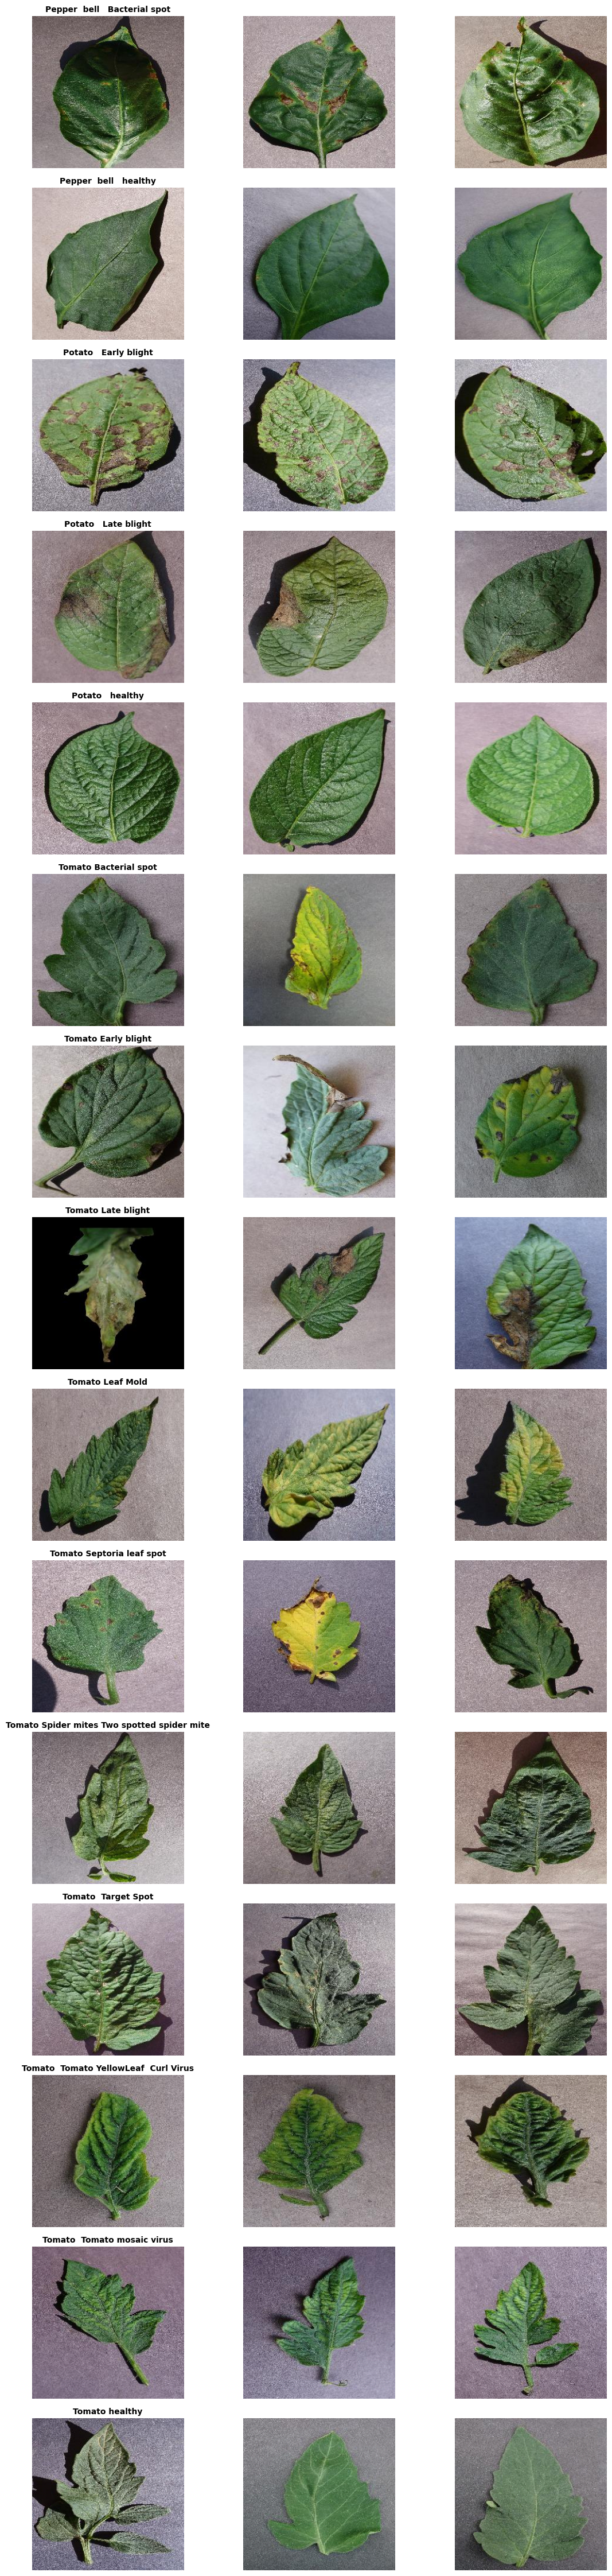

In [27]:
# Display sample images from each class
n_samples = 3
n_classes = len(classes)

fig, axes = plt.subplots(n_classes, n_samples, figsize=(12, n_classes * 3))

for i, class_name in enumerate(classes):
    class_path = data_dir / class_name
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.JPG"))
    
    sample_imgs = np.random.choice(images, min(n_samples, len(images)), replace=False)
    
    for j, img_path in enumerate(sample_imgs):
        try:
            img = Image.open(img_path)
            if n_classes == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name.replace('_', ' '), fontsize=10, fontweight='bold')
            img.close()
        except Exception as e:
            print(f"Error displaying {img_path}: {e}")

plt.tight_layout()
plt.savefig('../data/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

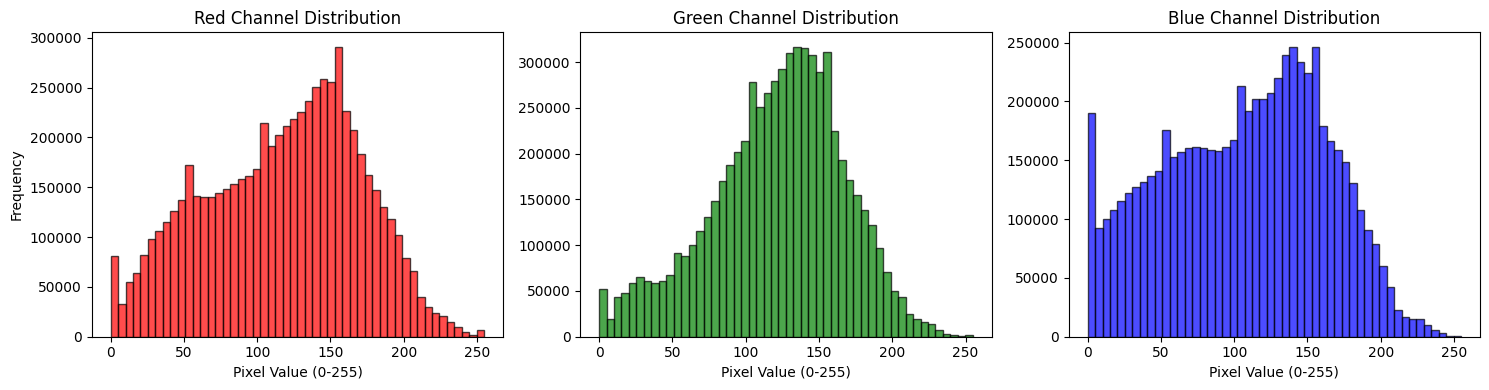


Red Channel - Mean: 117.28, Std: 52.97
Green Channel - Mean: 121.47, Std: 45.45
Blue Channel - Mean: 106.82, Std: 55.03


In [28]:
# Analyze pixel value distribution
sample_for_intensity = np.random.choice(all_image_paths, min(100, len(all_image_paths)), replace=False)

red_values = []
green_values = []
blue_values = []

for img_path in sample_for_intensity:
    try:
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)
        
        red_values.extend(img_array[:, :, 0].flatten())
        green_values.extend(img_array[:, :, 1].flatten())
        blue_values.extend(img_array[:, :, 2].flatten())
        
        img.close()
    except Exception as e:
        print(f"Error: {e}")

# Plot pixel distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(red_values, bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0].set_title('Red Channel Distribution')
axes[0].set_xlabel('Pixel Value (0-255)')
axes[0].set_ylabel('Frequency')

axes[1].hist(green_values, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Green Channel Distribution')
axes[1].set_xlabel('Pixel Value (0-255)')

axes[2].hist(blue_values, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[2].set_title('Blue Channel Distribution')
axes[2].set_xlabel('Pixel Value (0-255)')

plt.tight_layout()
plt.savefig('../data/pixel_distribution.png', dpi=300)
plt.show()

print(f"\nRed Channel - Mean: {np.mean(red_values):.2f}, Std: {np.std(red_values):.2f}")
print(f"Green Channel - Mean: {np.mean(green_values):.2f}, Std: {np.std(green_values):.2f}")
print(f"Blue Channel - Mean: {np.mean(blue_values):.2f}, Std: {np.std(blue_values):.2f}")

## Color Channel Analysis
* Images lean slightly **Green** (Mean: ~121.5), which is expected for plant leaves, but the variance is consistent across channels.
* No unusual color casts or extreme brightness variations found.
*   **Processing Action**
    - Training from scratch, so using dataset-specific normalization stats
        - `mean = [0.46, 0.48, 0.42]`
        - `std = [0.21, 0.18, 0.22]`
    - These reflect the true color distribution of your plant disease images, giving the model a more accurate baseline than ImageNet stats which were derived from a very different dataset.

COLOR CHANNEL CORRELATION ANALYSIS

Color Channel Correlation Matrix:
            Red     Green      Blue
Red    1.000000  0.933957  0.910360
Green  0.933957  1.000000  0.828083
Blue   0.910360  0.828083  1.000000

Correlation Interpretation:
Red-Green: 0.934 → Strong correlation (channels carry similar info)
Red-Blue: 0.910 → Strong correlation (channels carry similar info)
Green-Blue: 0.828 → Strong correlation (channels carry similar info)


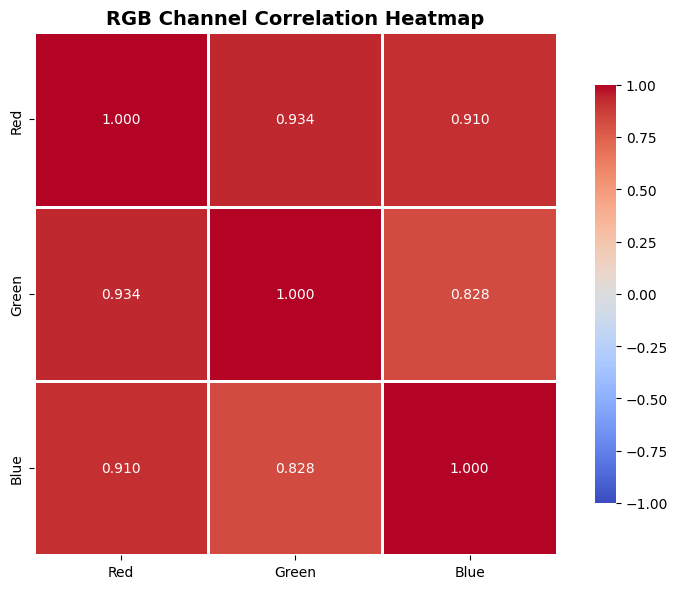

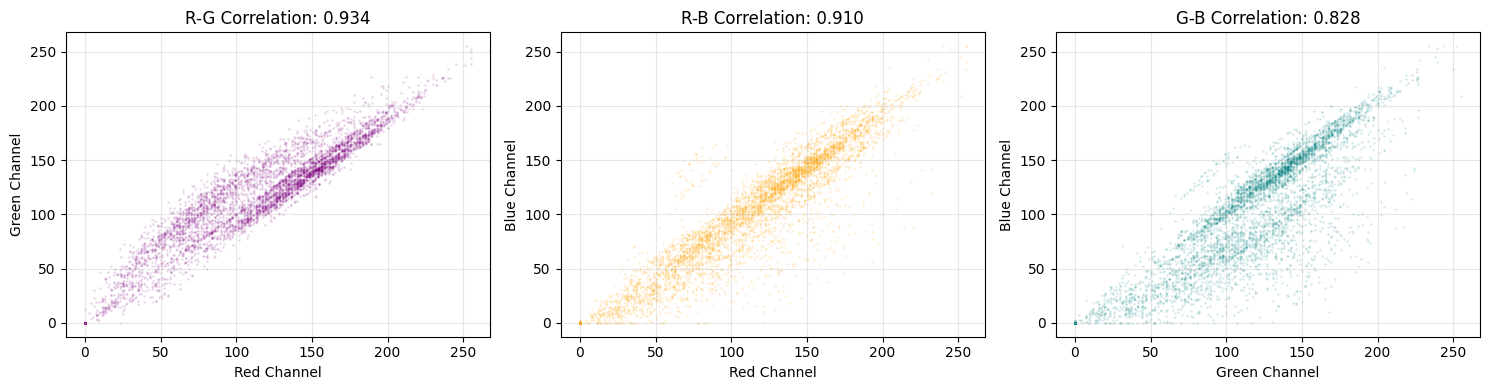


Color correlation analysis complete!
Analyzed 33,800 pixel samples from 50 images


In [36]:
# Color channel correlation analysis
print("COLOR CHANNEL CORRELATION ANALYSIS")

# Sample fewer images for correlation analysis (memory efficient)
sample_for_correlation = np.random.choice(all_image_paths, min(50, len(all_image_paths)), replace=False)

# Collect pixel values for correlation
r_vals = []
g_vals = []
b_vals = []

for img_path in sample_for_correlation:
    try:
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)
        
        # Subsample pixels (every 10th pixel to reduce memory)
        r_vals.extend(img_array[::10, ::10, 0].flatten())
        g_vals.extend(img_array[::10, ::10, 1].flatten())
        b_vals.extend(img_array[::10, ::10, 2].flatten())
        
        img.close()
    except Exception as e:
        print(f"Error: {e}")

# Create correlation matrix
color_data = pd.DataFrame({
    'Red': r_vals,
    'Green': g_vals,
    'Blue': b_vals
})

correlation_matrix = color_data.corr()

print("\nColor Channel Correlation Matrix:")
print(correlation_matrix)

# Interpret correlations
print("\nCorrelation Interpretation:")
for i, ch1 in enumerate(['Red', 'Green', 'Blue']):
    for j, ch2 in enumerate(['Red', 'Green', 'Blue']):
        if i < j:
            corr_val = correlation_matrix.iloc[i, j]
            print(f"{ch1}-{ch2}: {corr_val:.3f}", end=" → ")
            if abs(corr_val) > 0.8:
                print("Strong correlation (channels carry similar info)")
            elif abs(corr_val) > 0.5:
                print("Moderate correlation")
            else:
                print("Weak correlation (channels are independent)")

# Visualize correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, fmt='.3f')
plt.title('RGB Channel Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../data/color_correlation.png', dpi=300)
plt.show()

# Scatter plots for channel relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Subsample for plotting (too many points slow down visualization)
plot_sample = np.random.choice(len(r_vals), min(5000, len(r_vals)), replace=False)

axes[0].scatter(np.array(r_vals)[plot_sample], np.array(g_vals)[plot_sample], 
                alpha=0.1, s=1, c='purple')
axes[0].set_xlabel('Red Channel')
axes[0].set_ylabel('Green Channel')
axes[0].set_title(f'R-G Correlation: {correlation_matrix.iloc[0, 1]:.3f}')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(np.array(r_vals)[plot_sample], np.array(b_vals)[plot_sample], 
                alpha=0.1, s=1, c='orange')
axes[1].set_xlabel('Red Channel')
axes[1].set_ylabel('Blue Channel')
axes[1].set_title(f'R-B Correlation: {correlation_matrix.iloc[0, 2]:.3f}')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(np.array(g_vals)[plot_sample], np.array(b_vals)[plot_sample], 
                alpha=0.1, s=1, c='teal')
axes[2].set_xlabel('Green Channel')
axes[2].set_ylabel('Blue Channel')
axes[2].set_title(f'G-B Correlation: {correlation_matrix.iloc[1, 2]:.3f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/channel_scatter_plots.png', dpi=300)
plt.show()

print("\nColor correlation analysis complete!")
print(f"Analyzed {len(r_vals):,} pixel samples from {len(sample_for_correlation)} images")

## Color Channel Correlation

The Red, Green, and Blue channels exhibit **very high correlation** (>0.82), meaning they carry largely redundant information. This redundancy occurs in natural plant images where lighting affects all channels uniformly.

**Key Implications**
- The redundant information suggests the model might focus too much on overall intensity rather than the specific color differences critical for disease diagnosis (e.g., yellowing vs browning leaves have subtle channel ratio differences that can be masked by lighting).
- While grayscale conversion is technically viable due to high correlation, retaining full color is essential for distinguishing subtle disease patterns.

**Processing Action**
- No mandatory changes required.
- Consider experimenting with **HSV or LAB color space** as an alternative to RGB. These separate intensity from color information, potentially helping the model focus on disease-relevant color shifts rather than brightness alone.


Analyzing: Pepper__bell___Bacterial_spot

Analyzing: Pepper__bell___healthy

Analyzing: Potato___Early_blight

Analyzing: Potato___Late_blight

Analyzing: Potato___healthy

Analyzing: Tomato_Bacterial_spot

Analyzing: Tomato_Early_blight

Analyzing: Tomato_Late_blight

Analyzing: Tomato_Leaf_Mold

Analyzing: Tomato_Septoria_leaf_spot

Analyzing: Tomato_Spider_mites_Two_spotted_spider_mite

Analyzing: Tomato__Target_Spot

Analyzing: Tomato__Tomato_YellowLeaf__Curl_Virus

Analyzing: Tomato__Tomato_mosaic_virus

Analyzing: Tomato_healthy


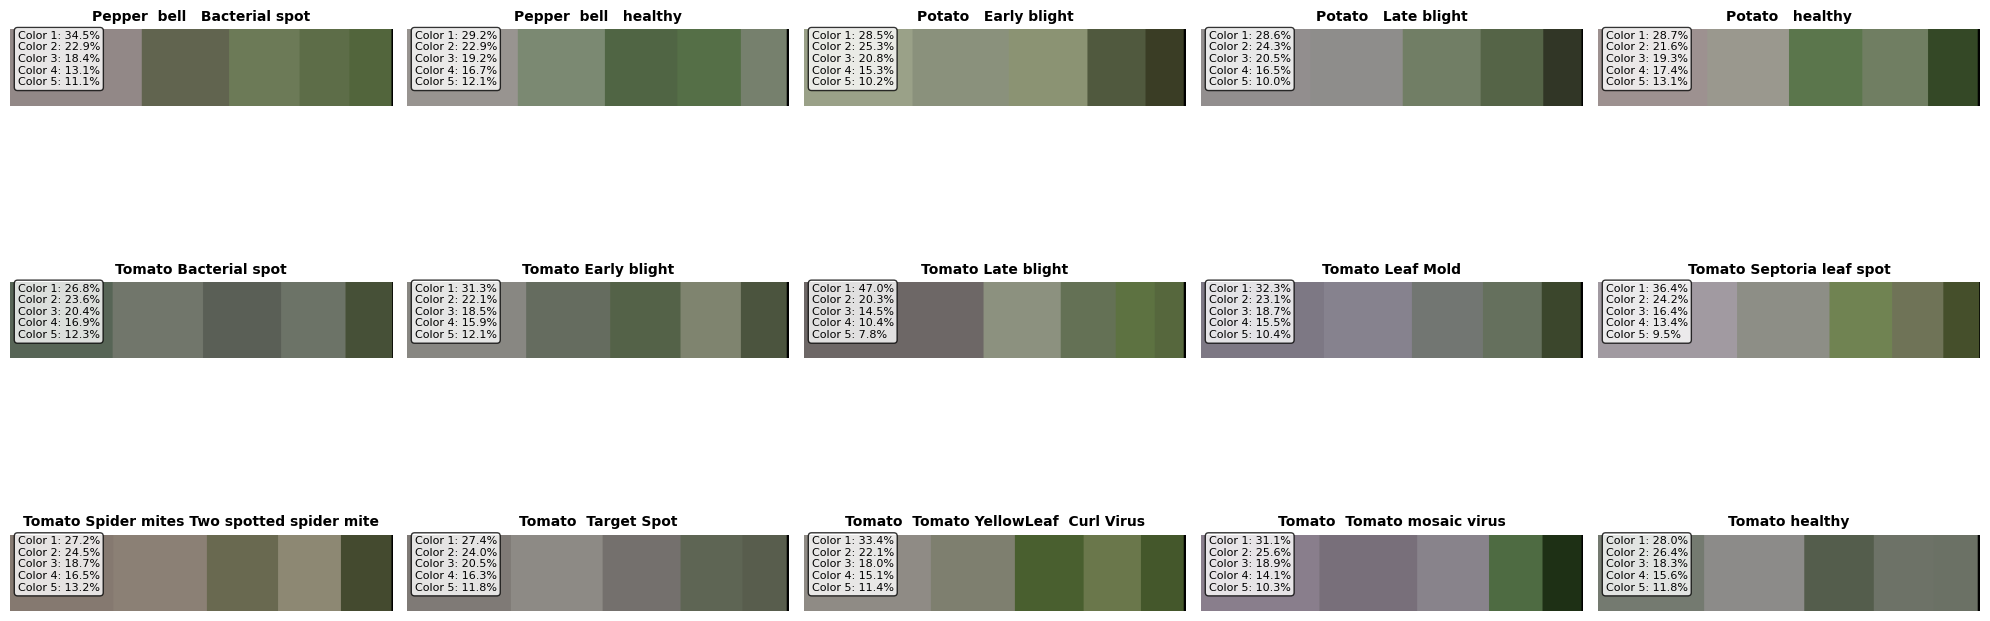


 Dominant color extraction complete!


In [35]:
def extract_dominant_colors(image_path, n_colors=5):
    """Extract n dominant colors from an image using K-means clustering"""
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((img.shape[0] * img.shape[1], 3))
    
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(img)
    
    colors = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # Calculate percentage of each color
    label_counts = Counter(labels)
    total_pixels = len(labels)
    percentages = [(label_counts[i] / total_pixels) * 100 for i in range(n_colors)]
    
    # Sort by percentage
    sorted_indices = np.argsort(percentages)[::-1]
    colors = colors[sorted_indices]
    percentages = [float(percentages[i]) for i in sorted_indices]
    
    return colors, percentages

# Extract dominant colors for each class
dominant_colors_per_class = {}
n_samples_per_class = 10
n_dominant_colors = 5

for class_name in classes:
    print(f"\nAnalyzing: {class_name}")
    class_path = data_dir / class_name
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.JPG"))
    
    if len(images) == 0:
        print(f"  No images found, skipping.")
        continue
    
    sample_imgs = np.random.choice(images, min(n_samples_per_class, len(images)), replace=False)
    
    all_colors = []
    all_percentages = []
    
    for img_path in sample_imgs:
        try:
            colors, percentages = extract_dominant_colors(img_path, n_dominant_colors)
            all_colors.append(colors)
            all_percentages.append(percentages)
        except Exception as e:
            print(f"  Error processing {img_path}: {e}")
    
    if len(all_colors) == 0:
        print(f"  All images failed, skipping.")
        continue
    
    avg_colors = np.mean(np.array(all_colors), axis=0)  
    avg_percentages = np.mean(np.array(all_percentages), axis=0) 
    
    dominant_colors_per_class[class_name] = {
        'colors': avg_colors,
        'percentages': avg_percentages
    }

# Visualize dominant colors for each class
n_classes_found = len(dominant_colors_per_class)
n_cols = 5
n_rows = (n_classes_found + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

for idx, (class_name, data) in enumerate(dominant_colors_per_class.items()):
    ax = axes[idx]
    cls_colors = np.array(data['colors'])   
    cls_pcts = np.array(data['percentages']) 
    
    # Create color palette strip
    color_palette = np.zeros((100, 500, 3))
    x_start = 0
    
    for i in range(len(cls_pcts)):
        x_end = x_start + int(cls_pcts[i] * 5)
        color_palette[:, x_start:x_end] = cls_colors[i] / 255.0
        x_start = x_end
    
    ax.imshow(color_palette)
    ax.axis('off')
    ax.set_title(f"{class_name.replace('_', ' ')}", fontsize=10, fontweight='bold')
    
    # Add color percentages as text
    text_str = '\n'.join([f"Color {i+1}: {cls_pcts[i]:.1f}%" for i in range(len(cls_pcts))])
    ax.text(0.02, 0.98, text_str, transform=ax.transAxes, 
            fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Hide unused subplots
for idx in range(n_classes_found, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../data/dominant_colors_per_class.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Dominant color extraction complete!")

## Dominant Color Analysis
* All classes share a very similar palette of **muted greens, greys, and browns**. 
  There is no distinct "color signature" for any specific disease.
* The model cannot rely on simple color histograms to classify diseases 
  (e.g., "yellow = virus"). It *must* learn structural features 
  (leaf spots, lesions, curling).

**Processing Action**
- Since color is not a strong discriminator, brightness/contrast/saturation 
  can be augmented aggressively to improve robustness to lighting changes.
- Keep augmentation within **realistic lighting variation ranges** 
  some classes like `Tomato_YellowLeaf__Curl_Virus` do have color-relevant 
  symptoms (yellowing) that could be destroyed by extreme saturation shifts, 
  potentially misleading the model.

In [6]:
# Corrupted/Unreadable File Audit
print("Auditing files for corruption or read errors...")

corrupted_files = []
unreadable_files = []

for img_path in all_image_paths:
    try:
        img = Image.open(img_path)
        img.verify() 
    except Exception as e:
        corrupted_files.append({'path': str(img_path), 'error': str(e)})

    try:
        img = cv2.imread(str(img_path))
        if img is None:
            unreadable_files.append(str(img_path))
    except Exception as e:
        unreadable_files.append(str(img_path))

print(f"Total images audited: {len(all_image_paths)}")
print(f"Corrupted/truncated files (PIL): {len(corrupted_files)}")
print(f"Unreadable files (OpenCV): {len(unreadable_files)}")

if corrupted_files:
    print("\nCorrupted files:")
    for f in corrupted_files:
        print(f"  {f['path']} — {f['error']}")

if unreadable_files:
    print("\nUnreadable files:")
    for f in unreadable_files:
        print(f"  {f}")

# Save to file for exclusion in preprocessing
import json
audit_results = {
    'corrupted': corrupted_files,
    'unreadable': unreadable_files
}
with open('../data/processed/corrupted_files.json', 'w') as f:
    json.dump(audit_results, f, indent=2)

print("\nAudit results saved to ../data/processed/corrupted_files.json")

Auditing files for corruption or read errors...
Total images audited: 20637
Corrupted/truncated files (PIL): 0
Unreadable files (OpenCV): 0

Audit results saved to ../data/processed/corrupted_files.json


In [32]:
# Save exploration results
metadata = {
    'total_images': int(df_distribution['Image_Count'].sum()),
    'num_classes': len(classes),
    'classes': classes,
    'class_distribution': df_distribution.to_dict('records'),
    'image_properties': {
        'mean_width': float(np.mean(image_properties['width'])),
        'mean_height': float(np.mean(image_properties['height'])),
        'std_width': float(np.std(image_properties['width'])),
        'std_height': float(np.std(image_properties['height'])),
        'mean_aspect_ratio': float(np.mean(aspect_ratios)),
        'std_aspect_ratio': float(np.std(aspect_ratios)),
        'common_format': pd.Series(image_properties['format']).mode()[0],
        'common_mode': pd.Series(image_properties['mode']).mode()[0]
    },
    'corrupted_images': corrupted_images,
    'imbalance_ratio': float(imbalance_ratio),
    'recommended_target_size': [224, 224], 
    'normalization_method': 'rescale_1_255'  
}

# Save to JSON
with open('../data/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)